In [5]:
import tensorflow as tf
import numpy as np
from keras.layers import *
from keras.models import Model, Sequential
from IPython.display import Image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

以 Hierarchical Attention Networks for Document Classification 這篇為範例 [paper](http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf)

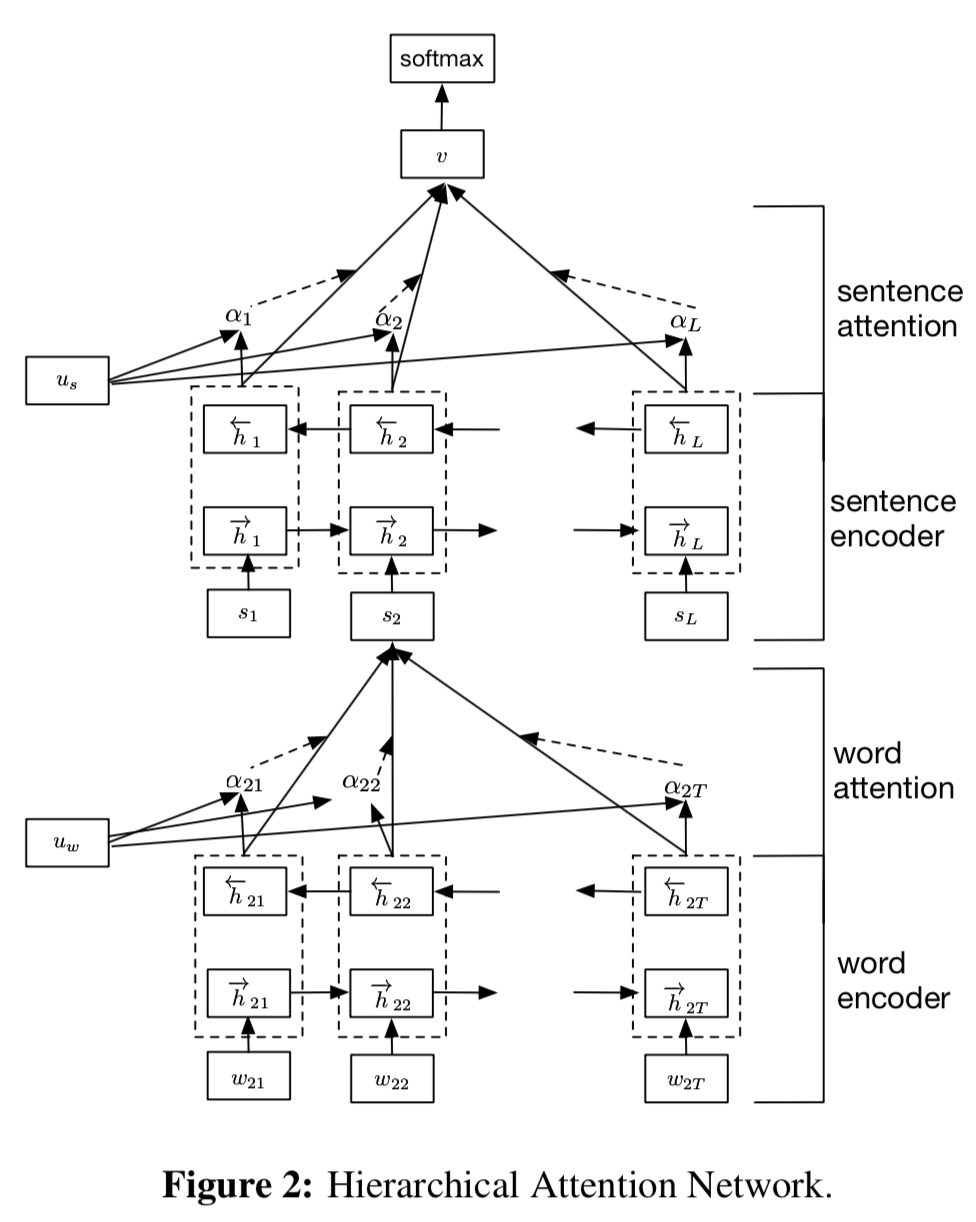

In [8]:
Image(filename="fig/fig2.png", width=500, height=500)

### 概念

文章是有階層的，一篇文章由一些句子組成、一句由一些字組成   
所以這篇paper提出2個層次的"encoder": 1. word_encoder => 組成一句 2. sentence_encoder => 組成文章

### 圖解

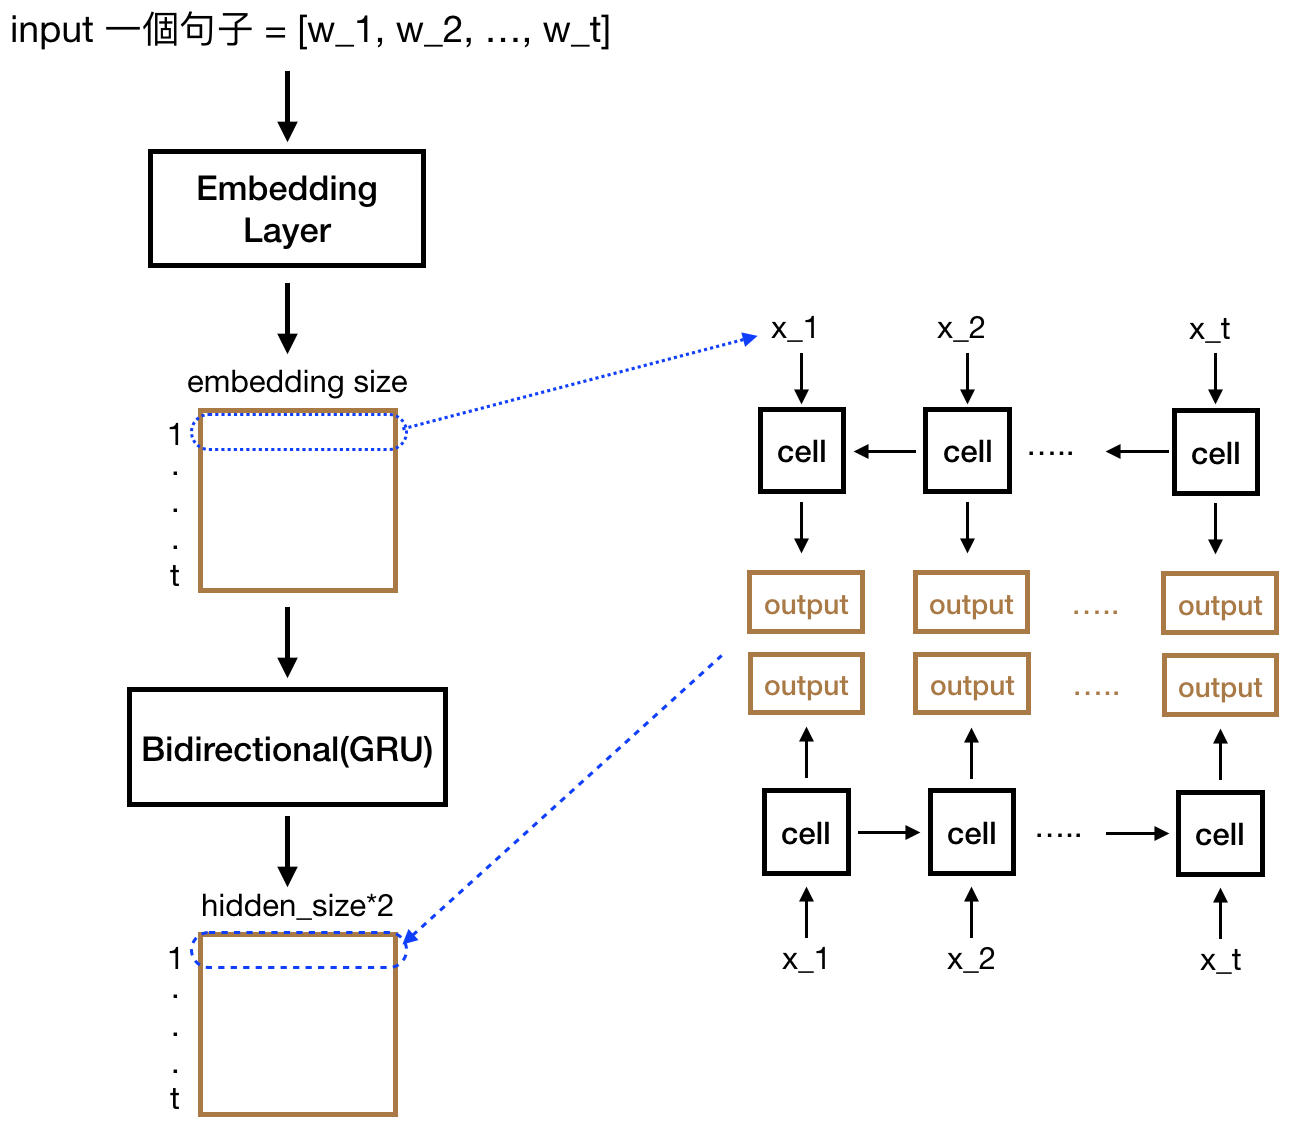

In [28]:
Image(filename="fig/1.png", width=500, height=500)

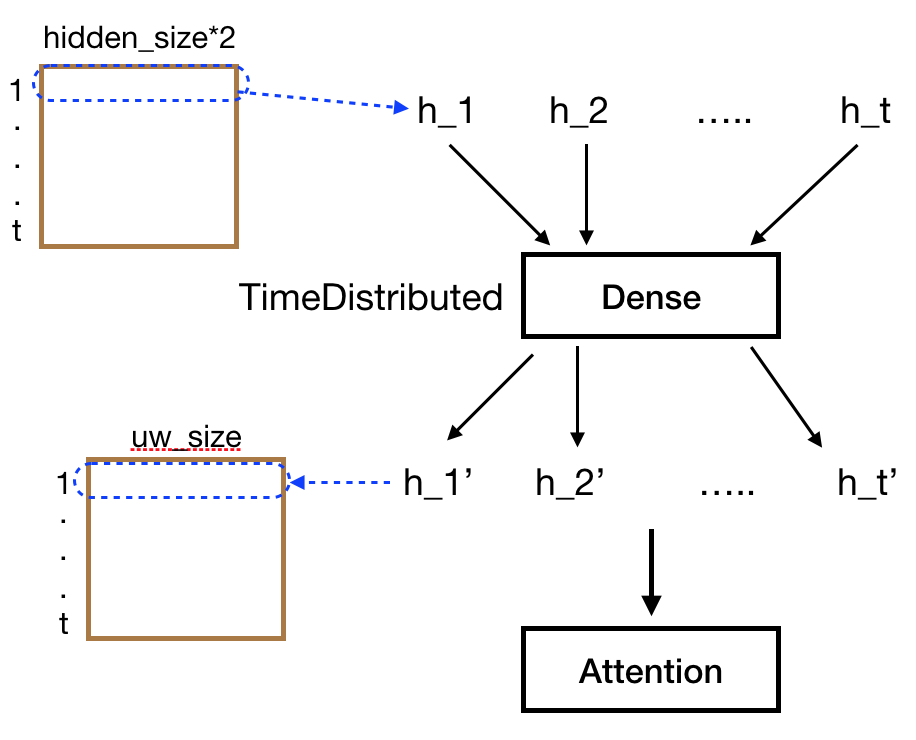

In [32]:
Image(filename="fig/2.png", width=400, height=400)

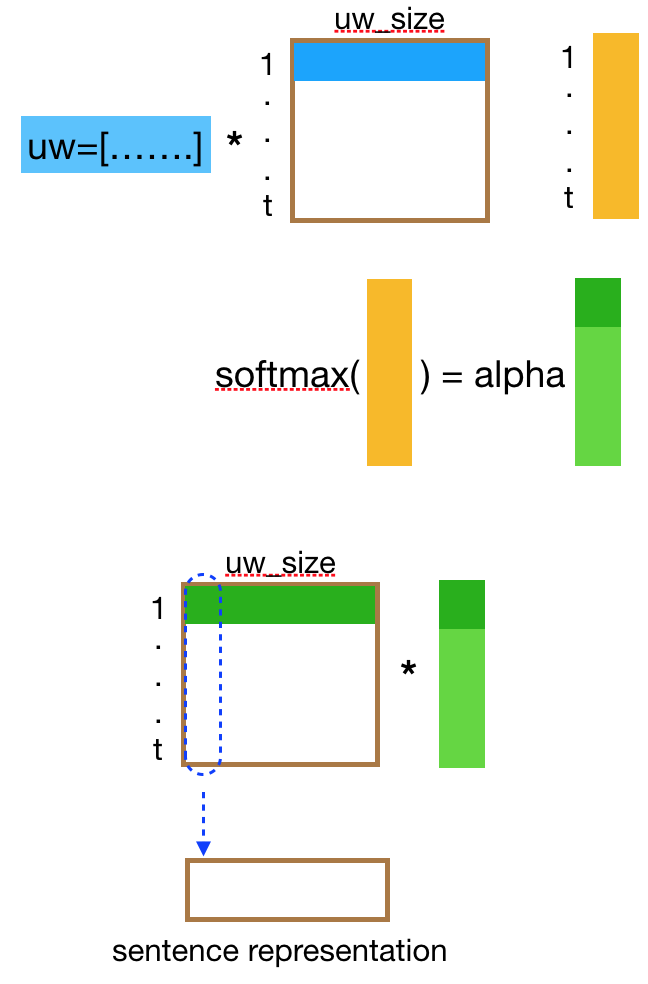

In [31]:
Image(filename="fig/3.png", width=300, height=300)

### 要探索的行為
1. Embedding(mask_zero=True)
2. Bidirectional()
3. GRU()+GRU(go_backwards=True)
4. Attention每個步驟

## model

In [9]:
class Attention(Layer):
    def __init__(self, **kwargs):
        self.att_size = kwargs.pop("att_size")
        self.output_dim = kwargs.pop("output_dim")
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.uw = self.add_weight(
            name="attention_size", 
            shape=(self.att_size, ),
            initializer="uniform",
            trainable=True)
        super(Attention, self).build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, x):
        m = tf.reduce_sum(x * self.uw, axis=-1)
        alpha = tf.nn.softmax(m)
        s = x * tf.expand_dims(alpha, axis=-1)
        return tf.reduce_mean(s, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def compute_mask(self, x, mask=None):
        return None
    
    def get_config(self):
        config = {
            "att_size": self.att_size,
            "output_dim": self.output_dim,
        }
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [50]:
hidden_size = 2
uw_size = 10

In [51]:
# shape = number of words
input_sentence_i = Input(shape=(None,), name="input_sentence_i", dtype="int32")

# output shape = (num_words, embedding_size)
embedding = Embedding(5, 3, mask_zero=True, name="word_embedding")(input_sentence_i)

# output shape = (time_steps, hidden_size*2). 在這裡 time_steps = None
word_h_seq = Bidirectional(GRU(hidden_size, return_sequences=True), name="word_h_seq")(embedding)

# 用 TimeDistributed 對 input=(time_steps, hidden_size*2)的每個 time_steps apply a same Dense layer
# output shape = (time_steps, uw_size)
word_mlp = TimeDistributed(Dense(uw_size, activation="tanh"), name="word_mlp")(word_h_seq)

# 將 word hidden state sequence 丟進去算 attention，得到這句 input_sentence_i representation
# si_representation = Lambda(word_attention, output_shape=(hidden_size*2,), name="si_representation")(word_mlp)
si_representation = Attention(att_size=uw_size, output_dim=hidden_size*2, name="si_representation")(word_mlp)

In [52]:
sent_encoder = Model(inputs=input_sentence_i, outputs=si_representation)

In [53]:
sent_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_sentence_i (InputLayer (None, None)              0         
_________________________________________________________________
word_embedding (Embedding)   (None, None, 3)           15        
_________________________________________________________________
word_h_seq (Bidirectional)   (None, None, 4)           72        
_________________________________________________________________
word_mlp (TimeDistributed)   (None, None, 10)          50        
_________________________________________________________________
si_representation (Attention (None, 4)                 10        
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


### 1. Embedding(mask_zero=True)

In [34]:
data_in = np.array([
    [1, 2, 0, 0],
    [3, 0, 0, 0]
])

In [54]:
m = Model(inputs=input_sentence_i, outputs=embedding)

In [55]:
p = m.predict(data_in)
print(p.shape)
p

(2, 4, 3)


array([[[-0.03444493, -0.02582147, -0.0101629 ],
        [ 0.00528768, -0.0097139 ,  0.01526406],
        [-0.00726907, -0.00625498,  0.02441329],
        [-0.00726907, -0.00625498,  0.02441329]],

       [[-0.00450097,  0.00816773,  0.01644186],
        [-0.00726907, -0.00625498,  0.02441329],
        [-0.00726907, -0.00625498,  0.02441329],
        [-0.00726907, -0.00625498,  0.02441329]]], dtype=float32)

### 2. Bidirectional

In [58]:
data_in

array([[1, 2, 0, 0],
       [3, 0, 0, 0]])

In [56]:
m = Model(inputs=input_sentence_i, outputs=word_h_seq)

In [57]:
p = m.predict(data_in)
print(p.shape)
p

(2, 4, 4)


array([[[ 0.00481459, -0.00336826, -0.01056372, -0.00669654],
        [-0.00221314, -0.00035975, -0.00014912,  0.00079129],
        [-0.00221314, -0.00035975,  0.        ,  0.        ],
        [-0.00221314, -0.00035975,  0.        ,  0.        ]],

       [[ 0.00574728,  0.00624466,  0.00045189,  0.00731253],
        [ 0.00574728,  0.00624466,  0.        ,  0.        ],
        [ 0.00574728,  0.00624466,  0.        ,  0.        ],
        [ 0.00574728,  0.00624466,  0.        ,  0.        ]]], dtype=float32)

### 3. GRU()+GRU(go_backwards=True)

In [119]:
data_in

array([[1, 2, 0, 0],
       [3, 0, 0, 0]])

In [132]:
i = Input(shape=(None,), dtype="int32")
e = Embedding(5, 3, mask_zero=True)(i)
fw = GRU(hidden_size, return_sequences=True)(e)
bw = GRU(hidden_size, return_sequences=True, go_backwards=True)(e)

In [133]:
m = Model(inputs=i, outputs=[e, fw, bw])

In [134]:
out_e, out_fw, out_bw = m.predict(data_in)
out_e.shape, out_fw.shape, out_bw.shape

((2, 4, 3), (2, 4, 2), (2, 4, 2))

In [135]:
out_e

array([[[ 0.0027773 , -0.00455352,  0.00914625],
        [-0.04158719,  0.02096497, -0.03005202],
        [-0.01902788, -0.03694405, -0.02786545],
        [-0.01902788, -0.03694405, -0.02786545]],

       [[-0.00270035,  0.03982134,  0.04850009],
        [-0.01902788, -0.03694405, -0.02786545],
        [-0.01902788, -0.03694405, -0.02786545],
        [-0.01902788, -0.03694405, -0.02786545]]], dtype=float32)

In [136]:
out_fw

array([[[ 0.00182942, -0.0025726 ],
        [ 0.00265873, -0.00082716],
        [ 0.00265873, -0.00082716],
        [ 0.00265873, -0.00082716]],

       [[-0.01023764, -0.00509854],
        [-0.01023764, -0.00509854],
        [-0.01023764, -0.00509854],
        [-0.01023764, -0.00509854]]], dtype=float32)

In [137]:
out_bw

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.00991068, -0.00318062],
        [ 0.00637324, -0.00386279]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [-0.0022387 , -0.00280843]]], dtype=float32)

### 4. Attention每個步驟

In [90]:
m = Model(inputs=input_sentence_i, outputs=[word_mlp, si_representation])

In [91]:
p, output = m.predict(data_in)
print(p.shape)
p

(2, 4, 10)


array([[[  5.93067240e-03,  -3.55477119e-03,   2.46969308e-03,
          -4.36402392e-03,  -8.71937163e-03,   3.66271823e-03,
           1.26307001e-04,  -8.57273489e-03,   2.75087077e-03,
          -4.66417801e-03],
        [  1.55544738e-04,   1.33429212e-03,  -1.30131585e-03,
           1.17070263e-03,   1.70290563e-03,  -9.92396264e-04,
           9.47077526e-04,  -1.74606394e-04,   1.31966328e-04,
           3.77509947e-04],
        [  3.65587795e-04,   1.27049536e-03,  -1.41865970e-03,
           7.38850445e-04,   1.25127367e-03,  -1.12647470e-03,
           1.16129592e-03,  -6.55078547e-05,   5.62979898e-04,
           8.65963579e-04],
        [  3.65587795e-04,   1.27049536e-03,  -1.41865970e-03,
           7.38850445e-04,   1.25127367e-03,  -1.12647470e-03,
           1.16129592e-03,  -6.55078547e-05,   5.62979898e-04,
           8.65963579e-04]],

       [[ -3.80638917e-03,  -3.85015318e-03,   5.67402691e-03,
           3.02808010e-03,   3.12239188e-03,   3.19852168e-03,
    

In [92]:
output

array([[  4.26061859e-04,   2.00536888e-05,  -1.04326151e-04,
         -1.07202854e-04,  -2.82074674e-04,   2.60645174e-05,
          2.12252868e-04,  -5.54859289e-04,   2.50539422e-04,
         -1.59647170e-04],
       [ -4.47948754e-04,  -1.11078483e-03,   1.25097483e-03,
          6.30318973e-05,  -1.70568528e-05,   6.19849423e-04,
         -9.34474869e-04,   8.12874816e-04,  -3.18714214e-04,
         -3.29914656e-05]], dtype=float32)

In [93]:
m.layers

In [94]:
uw_weight = m.layers[4].get_weights()[0]
uw_weight

array([ 0.04941324, -0.02930847, -0.04112362,  0.00946905, -0.0091226 ,
        0.04700624, -0.03563514,  0.04638026, -0.04425155,  0.03012607], dtype=float32)

In [102]:
x = tf.constant(p)
uw = tf.constant(uw_weight)

In [96]:
alpha0 = sess.run(tf.reduce_sum(x * uw, axis=-1))
alpha0

array([[ -1.58283568e-04,  -6.53179231e-05,  -6.14468372e-05,
         -6.14468372e-05],
       [  2.90721131e-04,   2.92301556e-04,   2.92301556e-04,
          2.92301556e-04]], dtype=float32)

In [99]:
np.dot(uw_weight, p[0][0]), np.dot(uw_weight, p[0][1])

(-0.00015828358, -6.5317923e-05)

In [98]:
alpha = sess.run(tf.nn.softmax(alpha0))
alpha

array([[ 0.24998207,  0.2500053 ,  0.25000629,  0.25000629],
       [ 0.24999972,  0.25000012,  0.25000012,  0.25000012]], dtype=float32)

In [103]:
sess.run(tf.expand_dims(alpha, axis=-1))

array([[[ 0.24998207],
        [ 0.2500053 ],
        [ 0.25000629],
        [ 0.25000629]],

       [[ 0.24999972],
        [ 0.25000012],
        [ 0.25000012],
        [ 0.25000012]]], dtype=float32)

In [107]:
s = sess.run(x * tf.expand_dims(alpha, axis=-1))
s

array([[[  1.48256181e-03,  -8.88629060e-04,   6.17378973e-04,
          -1.09092775e-03,  -2.17968668e-03,   9.15613899e-04,
           3.15744874e-05,  -2.14303005e-03,   6.87668391e-04,
          -1.16596092e-03],
        [  3.88870103e-05,   3.33580101e-04,  -3.25335859e-04,
           2.92681856e-04,   4.25735430e-04,  -2.48104334e-04,
           2.36774402e-04,  -4.36525261e-05,   3.29922805e-05,
           9.43794876e-05],
        [  9.13992480e-05,   3.17631842e-04,  -3.54673859e-04,
           1.84717253e-04,   3.12826276e-04,  -2.81625747e-04,
           2.90331285e-04,  -1.63773748e-05,   1.40748511e-04,
           2.16496337e-04],
        [  9.13992480e-05,   3.17631842e-04,  -3.54673859e-04,
           1.84717253e-04,   3.12826276e-04,  -2.81625747e-04,
           2.90331285e-04,  -1.63773748e-05,   1.40748511e-04,
           2.16496337e-04]],

       [[ -9.51596186e-04,  -9.62537189e-04,   1.41850510e-03,
           7.57019152e-04,   7.80597096e-04,   7.99629488e-04,
    

In [113]:
(1.48256181e-03+3.88870103e-05+9.13992480e-05+9.13992480e-05)/4

0.000426061829075

In [114]:
(-7.48389866e-04+2.05474658e-04+2.05474658e-04+2.05474658e-04)/4

-3.299147299999999e-05

In [109]:
sess.run(tf.reduce_mean(s, axis=1))

array([[  4.26061859e-04,   2.00536888e-05,  -1.04326151e-04,
         -1.07202854e-04,  -2.82074674e-04,   2.60645174e-05,
          2.12252868e-04,  -5.54859289e-04,   2.50539422e-04,
         -1.59647170e-04],
       [ -4.47948754e-04,  -1.11078483e-03,   1.25097483e-03,
          6.30318973e-05,  -1.70568528e-05,   6.19849423e-04,
         -9.34474869e-04,   8.12874816e-04,  -3.18714214e-04,
         -3.29914656e-05]], dtype=float32)